<a href="https://colab.research.google.com/github/NHCh1/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [21]:
import numpy as np
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# Data Loading

In [11]:
url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Dli-mendeley_18.csv'
data = pd.read_csv(url, header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1,1,50,0,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,2,1,4,59,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,2,1,4,57,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,3,1,1,49,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


# Pre-processing

In [12]:
#Array of features
x = data.drop([48], axis=1)
print(x)

#Array of target
y = data[48]
print(y)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

In [13]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [14]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print('------------------------------------------------------------------')
print(x_test)

[[ 0.4264587  -0.76932106 -0.15488093 ...  0.39933321 -0.23638944
   0.76186885]
 [-1.06951269 -0.76932106 -0.69750681 ...  0.39933321  1.0884513
   0.76186885]
 [ 1.92243009  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
  -1.47048024]
 [-0.32152699  0.5460789   0.93037084 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  0.38774495 ...  0.39933321  1.0884513
   0.76186885]]
------------------------------------------------------------------
[[-0.32152699  0.5460789  -0.15488093 ...  0.39933321  1.0884513
   0.76186885]
 [ 9.40228702  0.5460789   0.38774495 ...  0.39933321 -0.23638944
   0.76186885]
 [-0.32152699 -0.76932106  2.0156226  ...  0.39933321 -0.23638944
   0.76186885]
 ...
 [ 0.4264587   0.5460789  -1.2401327  ... -1.51922032 -1.56123018
  -0.35430569]
 [-1.06951269 -0.76932106 -1.78275858 ...  0.39933321 -0.23638944
  -0.35430569]
 [-0.32152699  0.5460789  -0.154880

# XGBoost - Liong Chi Teng - TP065355

Define XGBoost Model

In [ ]:
xgb_basic = XGBClassifier(eval_metric='error',
                          use_label_encoder=False,
                          n_jobs=-1,
                          random_state=42,
                          verbosity=0
                          )

Performing feature selection

In [ ]:
selector = RFECV(xgb_basic, cv=5, n_jobs=-1)
selector.fit(x, y)

selected_cols = np.where(selector.ranking_ == 1)[0]
print(f"Selected feature indices: {selected_cols}")

xgb_pipe = make_pipeline(ColumnSelector(cols=selected_cols),
                         XGBClassifier(eval_metric='error',
                                       use_label_encoder=False,
                                       n_jobs=-1,
                                       random_state=42
                                       )
                         )

xgb_pipe.fit(x_train, y_train)
xgb_pipe_train = xgb_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_pipe_test = xgb_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
xgb_pipe_accuracy = xgb_pipe.score(x_test, y_test)
print(f"Accuracy: {xgb_pipe_accuracy:.8f}")

Selected feature indices: [ 0  1  2  3  4  5  8  9 10 11 13 14 15 18 20 21 22 24 25 26 27 28 29 30
 31 32 33 34 38 39 40 41 45 46 47]
Accuracy: 0.98433333


Finding best hyperparameters and best threshold

In [ ]:
param_dist = {'xgbclassifier__max_depth': [4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
              'xgbclassifier__n_estimators': [1000, 2000, 3000],
              'xgbclassifier__subsample': [0.7, 0.8, 0.9],
              'xgbclassifier__colsample_bytree': [0.7, 0.8, 0.9],
              'xgbclassifier__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]
              }

xgb_search = RandomizedSearchCV(xgb_pipe,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=5,
                                n_jobs=-1,
                                scoring='accuracy',
                                verbose=1
                                )

xgb_search.fit(x_train, y_train)
print("Best Hyperparameters:", xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]
xgb_model_train = xgb_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_model_test = xgb_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

thresholds = [i / 100 for i in range(1, 100)]
best_acc, best_thresh = 0, 0

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"Best Threshold: {best_thresh:.4f}, Best Accuracy: {best_acc:.8f}")
xgb_final_pred = (xgb_probs >= best_thresh).astype(int)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'xgbclassifier__subsample': 0.9, 'xgbclassifier__scale_pos_weight': 1.006305531670966, 'xgbclassifier__n_estimators': 2000, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.9}
Best Threshold: 0.5000, Best Accuracy: 0.98533333


XGBoost Model Training Result

In [ ]:
xgb_acc     = accuracy_score(y_test, xgb_final_pred)
xgb_prec    = precision_score(y_test, xgb_final_pred)
xgb_rec     = recall_score(y_test, xgb_final_pred)
xgb_f1      = f1_score(y_test, xgb_final_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs)

xgb_pipe_prob = xgb_pipe.predict_proba(x_test)[:, 1]
xgb_pipe_pred = (xgb_pipe_test >= 0.5).astype(int)

print("\nFinal Xgb Model Metrics")
print(f"Accuracy  : {xgb_acc:.4f}")
print(f"Precision : {xgb_prec:.4f}")
print(f"Recall    : {xgb_rec:.4f}")
print(f"F1-score  : {xgb_f1:.4f}")
print(f"ROC-AUC   : {xgb_roc_auc:.4f}")


Final Xgb Model Metrics
Accuracy  : 0.9853
Precision : 0.9822
Recall    : 0.9887
F1-score  : 0.9855
ROC-AUC   : 0.9982


# CNN Complex - Ng Hooi Chi - TP065587

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

# reshape input from 2D to 3D
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# MODEL - CNN_COMPLEX
def cnn_complex_tabular():
    model = Sequential()
    model.add(Input(shape=(48, 1)))
    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 7, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Train CNN
cnn_model = cnn_complex_tabular()
cnn_model.fit(x_train_cnn, y_train, epochs=25, batch_size=1000, verbose=0)

cnn_train_pred = cnn_model.predict(x_train_cnn)
cnn_test_pred = cnn_model.predict(x_test_cnn)

cnn_accuracy = roc_auc_score(y_test, cnn_test_pred)
print(f"ConvolutionalNN Accuracy: {cnn_accuracy:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
ConvolutionalNN Accuracy: 0.9941


# Gradient Boosting - Lee Zhi Hui - TP074075

In [ ]:
# MODEL - GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(max_depth=4, learning_rate=0.7)
gbc_model.fit(x_train, y_train)

gbc_train_pred = gbc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_test_pred = gbc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

gbc_accuracy = roc_auc_score(y_test, gbc_test_pred)
print(f"GradientBoosting Accuracy: {gbc_accuracy:.4f}")

GradientBoosting Accuracy: 0.9971


# Decision Tree - Ong Wing Xuan - TP065481

Define Decision Tree Model

In [15]:
dtc_model = DecisionTreeClassifier(max_depth=12)

Training Decision Tree Model

In [16]:
dtc_model.fit(x_train, y_train)
dtc_model_full = copy.deepcopy(dtc_model)

dtc_model_train = dtc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_model_test = dtc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

dtc_model_accuracy = dtc_model.score(x_test, y_test)
print(f"Dtc Plain Accuracy: {dtc_model_accuracy:.8f}")

Dtc Plain Accuracy: 0.96766667


Performing Feature Selection

In [17]:
selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)[0]
print(dtc_col)

dtc_pipe = make_pipeline(ColumnSelector(cols=dtc_col), dtc_model)

dtc_pipe.fit(x_train, y_train)
dtc_pipe_train = dtc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_pipe_test = dtc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
dtc_pipe_accuracy = dtc_pipe.score(x_test, y_test)
print(f"Dtc Pipe Accuracy: {dtc_pipe_accuracy:.8f}")

[ 0  2  3  4  8  9 11 13 14 20 21 22 24 26 27 28 29 31 33 34 38 39 45 47]
Dtc Pipe Accuracy: 0.96666667


Decision Tree Training Result

In [23]:
dtc_pipe_prob = dtc_pipe.predict_proba(x_test)[:, 1]
dtc_pipe_pred = (dtc_pipe_test >= 0.5).astype(int)

dtc_accuracy = accuracy_score(y_test, dtc_pipe_pred)
dtc_precision = precision_score(y_test, dtc_pipe_pred)
dtc_recall = recall_score(y_test, dtc_pipe_pred)
dtc_f1 = f1_score(y_test, dtc_pipe_pred)
dtc_roc_auc = roc_auc_score(y_test, dtc_pipe_prob)

print(f"Dtc Final Model Metrics:")
print(f"Accuracy:  {dtc_accuracy:.4f}")
print(f"Precision: {dtc_precision:.4f}")
print(f"Recall:    {dtc_recall:.4f}")
print(f"F1-score:  {dtc_f1:.4f}")
print(f"ROC-AUC:   {dtc_roc_auc:.4f}")

Dtc Final Model Metrics:
Accuracy:  0.9677
Precision: 0.9609
Recall:    0.9755
F1-score:  0.9681
ROC-AUC:   0.9604


# Stacked Model - Group Work

In [ ]:
# MODEL - STACKING
stacked_train = np.hstack([xgb_train_pred, cnn_train_pred, gbc_train_pred, dtc_train_pred])
stacked_test = np.hstack([xgb_test_pred, cnn_test_pred, gbc_test_pred, dtc_test_pred])

from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = meta_model.predict(stacked_test)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {acc:.4f}")

Stacked Model Accuracy: 0.9837


In [ ]:
# FEATURE SELECTION - XGBOOST

from sklearn.feature_selection import RFECV
selector = RFECV(xgb_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
xgb_col = np.where(selector.ranking_==1)
print(xgb_col)

from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline

pipe_xgb = make_pipeline(ColumnSelector(cols=(0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 15, 18, 20, 21, 22,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 45, 46,
       47)),xgb_model)

pipe_xgb.fit(x_train, y_train)
pipe_xgb_train = pipe_xgb.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_xgb_test = pipe_xgb.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_xgb_accuracy = roc_auc_score(y_test, pipe_xgb_test)
print(f"Pipe Xgb Accuracy: {pipe_xgb_accuracy:.4f}")

(array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 15, 18, 20, 21, 22,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 45, 46,
       47]),)
Pipe Xgb Accuracy: 0.9981


In [ ]:
# FEATURE SELECTION - CNN_COMPLEX

from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=30)
x_selected = selector.fit_transform(x, y)
cnn_cols = selector.get_support(indices=True)
print(cnn_cols)

cnn_x_train = x_train[:, cnn_cols].reshape(-1, len(cnn_cols), 1)
cnn_x_test = x_test[:, cnn_cols].reshape(-1, len(cnn_cols), 1)

pipe_cnn = cnn_complex_tabular()
pipe_cnn.fit(cnn_x_train, y_train, epochs=25, batch_size=1000, verbose=0)
pipe_cnn_train = pipe_cnn.predict(cnn_x_train)
pipe_cnn_test = pipe_cnn.predict(cnn_x_test)
pipe_cnn_accuracy = roc_auc_score(y_test, pipe_cnn_test)
print(f"Pipe Cnn Accuracy: {pipe_cnn_accuracy:.4f}")

[ 0  2  3  4  8 10 11 13 16 18 20 21 22 24 25 26 27 29 30 31 32 33 34 38
 39 43 44 45 46 47]
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Pipe Cnn Accuracy: 0.9928


In [ ]:
# FEATURE SELECTION - GRADIENT BOOSTING

selector = RFECV(gbc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
gbc_col = np.where(selector.ranking_==1)
print(gbc_col)

pipe_gbc = make_pipeline(ColumnSelector(cols=(0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 16, 20, 21, 22, 24,
       26, 27, 28, 29, 31, 33, 34, 38, 39, 40, 46, 47)),gbc_model)

pipe_gbc.fit(x_train, y_train)
pipe_gbc_train = pipe_gbc.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_gbc_test = pipe_gbc.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_gbc_accuracy = roc_auc_score(y_test, pipe_gbc_test)
print(f"Pipe Gbc Accuracy: {pipe_gbc_accuracy:.4f}")

(array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 13, 14, 16, 20, 21, 22, 24,
       26, 27, 28, 29, 31, 33, 34, 38, 39, 40, 46, 47]),)
Pipe Gbc Accuracy: 0.9973


In [ ]:
# FEATURE SELECTION - DECISION TREE

selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)
print(dtc_col)

pipe_dtc = make_pipeline(ColumnSelector(cols=(0,  2,  3,  4,  8,  9, 13, 14, 20, 21, 22, 24, 26, 27, 29, 33, 34, 38, 39, 45, 47)),dtc_model)

pipe_dtc.fit(x_train, y_train)
pipe_dtc_train = pipe_dtc.predict_proba(x_train)[:, 1].reshape(-1, 1)
pipe_dtc_test = pipe_dtc.predict_proba(x_test)[:, 1].reshape(-1, 1)
pipe_dtc_accuracy = roc_auc_score(y_test, pipe_dtc_test)
print(f"Pipe Dtc Accuracy: {pipe_dtc_accuracy:.4f}")

(array([ 0,  2,  3,  4,  8,  9, 13, 14, 20, 21, 22, 24, 26, 27, 28, 29, 33,
       34, 38, 39, 45, 47]),)
Pipe Dtc Accuracy: 0.9619


In [ ]:
# FEATURE SELECTION - STACKING

pipe_st_train = np.hstack([pipe_xgb_train, pipe_cnn_train, pipe_gbc_train, pipe_dtc_train])
pipe_st_test = np.hstack([pipe_xgb_test, pipe_cnn_test, pipe_gbc_test, pipe_dtc_test])

pipe_model = LogisticRegression()
pipe_model.fit(pipe_st_train, y_train)

y_pred_pipe = pipe_model.predict(pipe_st_test)
acc = accuracy_score(y_test, y_pred_pipe)
print(f"Stacked Model with Features Accuracy: {acc:.4f}")

Stacked Model with Features Accuracy: 0.9847


In [ ]:
# Create a dictionary from the actual test result and predicted result
comparison = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

true_positive = ((comparison['y_pred'] == 0) & (comparison['y_test'] == 0)).sum()
print(f"True Positive: {true_positive}")

true_negative = ((comparison['y_pred'] == 1) & (comparison['y_test'] == 1)).sum()
print(f"True Negative: {true_negative}")

false_positive = ((comparison['y_pred'] == 0) & (comparison['y_test'] == 1)).sum()
print(f"False Positive: {false_positive}")

false_negative = ((comparison['y_pred'] == 1) & (comparison['y_test'] == 0)).sum()
print(f"False Negative: {false_negative}")

accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.8f}")

True Positive: 1461
True Negative: 1492
False Positive: 19
False Negative: 28
Accuracy: 0.98433333


# Evaluation

## XGBoost

Classification report

In [ ]:
print(classification_report(y_test, xgb_final_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9885    0.9819    0.9852      1489
           1     0.9822    0.9887    0.9855      1511

    accuracy                         0.9853      3000
   macro avg     0.9854    0.9853    0.9853      3000
weighted avg     0.9854    0.9853    0.9853      3000



Dictionary of TP, TN, FP, FN

In [ ]:
xgb_y_pred = xgb_model.predict(x_test)
xgb_comparison = pd.DataFrame({'xgb_y_pred': xgb_y_pred, 'y_test': y_test})
xgb_true_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 0)).sum()
print(f"True Positive: {xgb_true_positive}")
xgb_true_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 1)).sum()
print(f"True Negative: {xgb_true_negative}")
xgb_false_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 1)).sum()
print(f"False Positive: {xgb_false_positive}")
xgb_false_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 0)).sum()
print(f"False Negative: {xgb_false_negative}")

True Positive: 1462
True Negative: 1494
False Positive: 17
False Negative: 27


Confusion Matrix

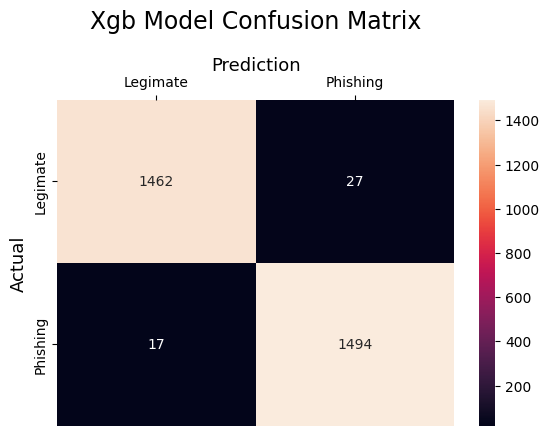

In [ ]:
cm = confusion_matrix(y_test, xgb_final_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Xgb Model Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Decision Tree

Classification report

In [26]:
dtc_y_pred = dtc_pipe.predict(x_test)
print(classification_report(y_test, dtc_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9721    0.9604    0.9662      1489
           1     0.9614    0.9729    0.9671      1511

    accuracy                         0.9667      3000
   macro avg     0.9668    0.9666    0.9667      3000
weighted avg     0.9667    0.9667    0.9667      3000



Dictionary of TP, TN, FP, FN

In [27]:
dtc_comparison = pd.DataFrame({'dtc_y_pred': dtc_y_pred, 'y_test': y_test})

dtc_true_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {dtc_true_positive}")
dtc_true_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {dtc_true_negative}")
dtc_false_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {dtc_false_positive}")
dtc_false_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {dtc_false_negative}")

True Positive: 1430
True Negative: 1470
False Positive: 41
False Negative: 59


Confusion Matrix

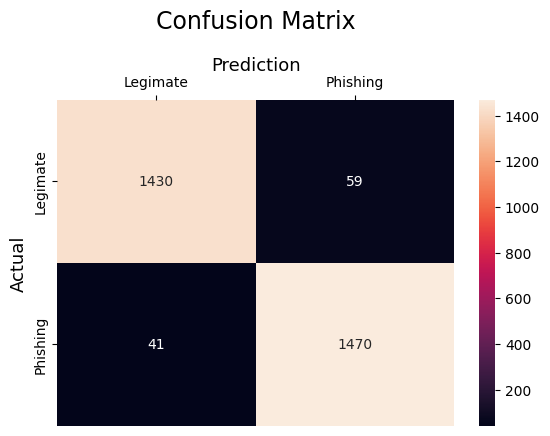

In [28]:
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Other

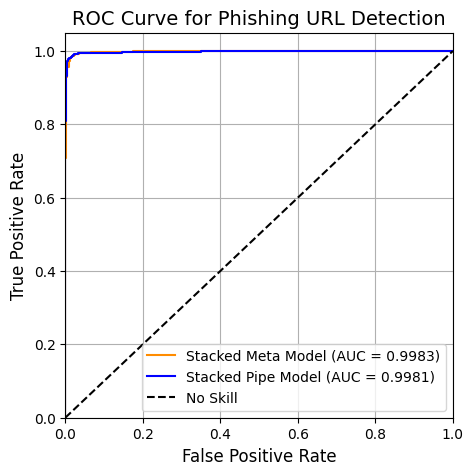

In [ ]:
# Receiver Operating Characteristic Curve
from sklearn.metrics import roc_curve, auc

y_prob_meta = meta_model.predict_proba(stacked_test)[:, 1]
y_prob_pipe = pipe_model.predict_proba(pipe_st_test)[:, 1]
fpr_meta, tpr_meta, thresholds_meta = roc_curve(y_test, y_prob_meta)
fpr_pipe, tpr_pipe, thresholds_pipe = roc_curve(y_test, y_prob_pipe)
roc_auc_meta = auc(fpr_meta, tpr_meta)
roc_auc_pipe = auc(fpr_pipe, tpr_pipe)

plt.figure(figsize=(5, 5))
plt.plot(fpr_meta, tpr_meta, label='Stacked Meta Model (AUC = %0.4f)' % roc_auc_meta, color='darkorange')
plt.plot(fpr_pipe, tpr_pipe, label='Stacked Pipe Model (AUC = %0.4f)' % roc_auc_pipe, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Phishing URL Detection', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

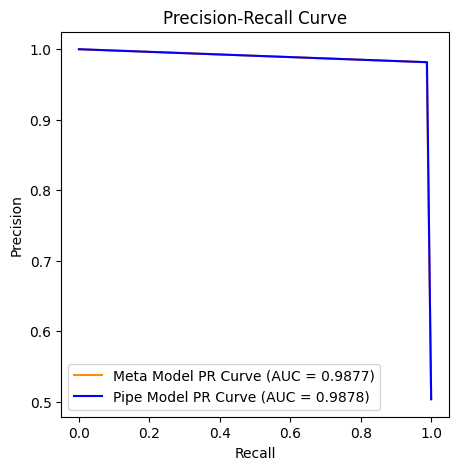

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc
precision_meta, recall_meta, thresholds_meta = precision_recall_curve(y_test, y_pred)
precision_pipe, recall_pipe, thresholds_pipe = precision_recall_curve(y_test, y_pred_pipe)
auc_score_meta = auc(recall_meta, precision_meta)
auc_score_pipe = auc(recall_pipe, precision_pipe)

plt.figure(figsize=(5, 5))
plt.plot(recall_meta, precision_meta, label=f'Meta Model PR Curve (AUC = {auc_score_meta:.4f})', color='darkorange')
plt.plot(recall_pipe, precision_pipe, label=f'Pipe Model PR Curve (AUC = {auc_score_pipe:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# Logistic Regression Coefficients
importance_scores = meta_model.coef_[0]
stacked_features = ['XGBoost', 'CNN', 'GradientBoosting', 'DecisionTree']
for name, coef in zip(stacked_features, importance_scores):
    print(f"{name} contribution weight: {coef:.4f}")

plt.bar(stacked_features, importance_scores)
plt.title('Meta Model Feature Importances (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

# Save Model

Saving Final XGB Model

In [ ]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

Saving Final Decision Tree Model

In [29]:
joblib.dump(dtc_pipe, 'dtc_model.pkl')

['dtc_model.pkl']